# Capstone Project: Predicting additional tax revenue for the state of Connecticut if sports wagering is legalized

## Problem Statement

The State Legislature of Connecticut is reviewing a bill to legalize sports wagering within the state. The State Legislature must carefully weigh pros and cons when deciding pass or reject the bill. If they pass the bill, the bill moves on to the Sentate for final approval. If the Senate approves, Connecticut would become the 12th state in the United States where sports wagering has been legalized.

A major consideration by the State Legislature is the potential revenue gain in the State General fund. All sources of gaming share revenue with the state and make transfers into the State General fund at the end of the fiscal year. While sports wagering itsself is likely to bring in new revenue for the state, the state must consider reductions in other revenue streams that the new sports wagering revenue stream may cause. 

Using Sports Wagering year-end reports we have for each state where sports wagering was legal in 2019 as well as state annual reports showing other streams of revenue, we will build and leverage an unsupervised linear regression model that will help predict if legazing sports wagering will lead to an increase or decrease in total revenue for Connecticut, using the other states as prototypes. After modeling, we will exmaine the model's mean squared error, helping us determine the success of the model. Our goal is to provide the state with a model that can predict revenue as closely as possible, giving the state more confidence to make their decision more clear.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [22]:
df = pd.read_csv('./data/wv_combined.csv')

## Cleaning / EDA

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 10 columns):
week_ending                53 non-null object
tickets_written            53 non-null int64
 voids                     53 non-null int64
tickets_cashed             53 non-null int64
mobile_taxable_receipts    31 non-null float64
retail_taxable_receipts    53 non-null int64
total_taxable_receipts     53 non-null int64
privilege_tax              53 non-null int64
admin_share                53 non-null int64
state_share                53 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 4.3+ KB


In [24]:
df.columns

Index(['week_ending', 'tickets_written', ' voids ', 'tickets_cashed',
       'mobile_taxable_receipts', 'retail_taxable_receipts',
       'total_taxable_receipts', 'privilege_tax', 'admin_share',
       'state_share'],
      dtype='object')

In [25]:
df.shape

(53, 10)

In [26]:
df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,5.300000e+01,53.000000,5.300000e+01,31.000000,5.300000e+01,5.300000e+01,53.000000,53.000000,53.000000
mean,3.195297e+06,68707.056604,3.834779e+06,170215.161290,2.616171e+05,3.611769e+05,36117.679245,5417.641509,30700.075472
std,1.182310e+06,31901.787858,2.274219e+06,221671.645695,3.724539e+05,4.994618e+05,49946.173978,7491.923701,42454.301575
min,2.066020e+05,3387.000000,2.015390e+05,-571570.000000,-8.448410e+05,-1.416411e+06,-141641.000000,-21246.000000,-120395.000000
25%,2.176969e+06,44266.000000,1.890579e+06,35048.000000,6.768800e+04,1.463590e+05,14636.000000,2195.000000,12441.000000
50%,3.680379e+06,67621.000000,3.554777e+06,149607.000000,2.436570e+05,2.846270e+05,28463.000000,4269.000000,24193.000000
75%,4.164430e+06,91090.000000,5.622406e+06,276460.000000,4.012870e+05,6.740090e+05,67401.000000,10110.000000,57291.000000
max,4.902465e+06,154935.000000,9.404206e+06,601782.000000,1.388791e+06,1.664244e+06,166424.000000,24964.000000,141461.000000


In [27]:
df.dtypes

week_ending                 object
tickets_written              int64
 voids                       int64
tickets_cashed               int64
mobile_taxable_receipts    float64
retail_taxable_receipts      int64
total_taxable_receipts       int64
privilege_tax                int64
admin_share                  int64
state_share                  int64
dtype: object

In [28]:
df['week_ending'] = pd.to_datetime(df['week_ending'])

In [29]:
df.dtypes

week_ending                datetime64[ns]
tickets_written                     int64
 voids                              int64
tickets_cashed                      int64
mobile_taxable_receipts           float64
retail_taxable_receipts             int64
total_taxable_receipts              int64
privilege_tax                       int64
admin_share                         int64
state_share                         int64
dtype: object

In [32]:
test = ' voids '
test.strip()

'voids'

In [33]:
df.columns = [col.strip() for col in df.columns]

In [34]:
df.isnull().sum().sort_values(ascending = False)

mobile_taxable_receipts    22
state_share                 0
admin_share                 0
privilege_tax               0
total_taxable_receipts      0
retail_taxable_receipts     0
tickets_cashed              0
voids                       0
tickets_written             0
week_ending                 0
dtype: int64

In [35]:
df[df.isna().any(axis=1)]

,week_ending,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
10,2019-03-16,2858410,70218,2565896,NaN,222296,222296,22230,3334,18895
11,2019-03-23,4418971,91090,3554777,NaN,773104,773104,77310,11597,65714
12,2019-03-30,3443807,67494,3025699,NaN,350615,350615,35061,5259,29802
13,2019-04-06,2385379,68355,2123295,NaN,193729,193729,19373,2906,16467
16,2019-04-27,2607302,49943,2587349,NaN,-29989,-29989,-2999,-450,-2549
17,2019-05-04,2296202,38167,1856748,NaN,401287,401287,40129,6019,34109
18,2019-05-11,2210385,30720,2190474,NaN,-10808,-10808,-1081,-162,-919
19,2019-05-18,2176969,44266,1975717,NaN,156986,156986,15699,2355,13344
20,2019-05-25,1984382,31461,1885233,NaN,67688,67688,6769,1015,5754
21,2019-06-01,2036091,22197,1691982,NaN,321912,321912,32191,4829,27363


In [36]:
df.fillna(0, inplace=True)

In [37]:
df.isnull().sum().sort_values(ascending = False)

state_share                0
admin_share                0
privilege_tax              0
total_taxable_receipts     0
retail_taxable_receipts    0
mobile_taxable_receipts    0
tickets_cashed             0
voids                      0
tickets_written            0
week_ending                0
dtype: int64

In [38]:
df.set_index('week_ending', inplace=True)

### Visualizing (this won't be an actual section)

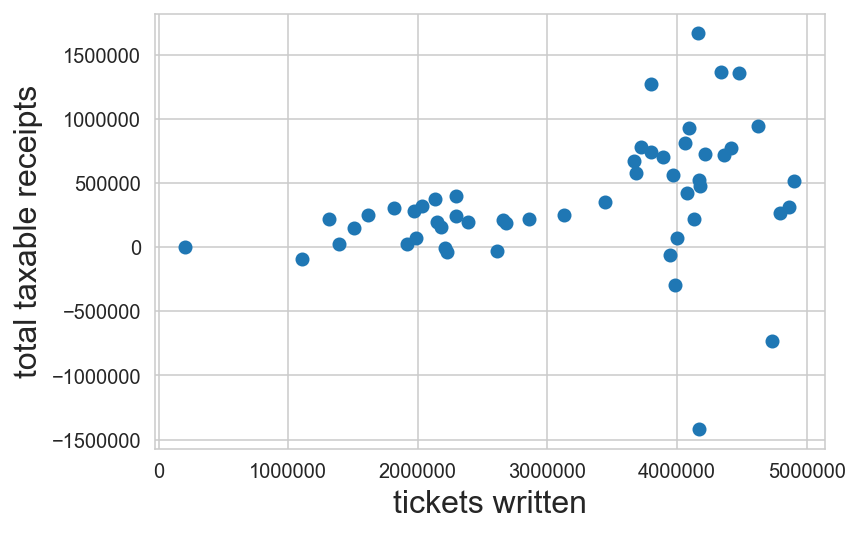

In [39]:
plt.scatter(df["tickets_written"], df["total_taxable_receipts"])
plt.xlabel("tickets written", fontsize = 16)
plt.ylabel("total taxable receipts", fontsize = 16);

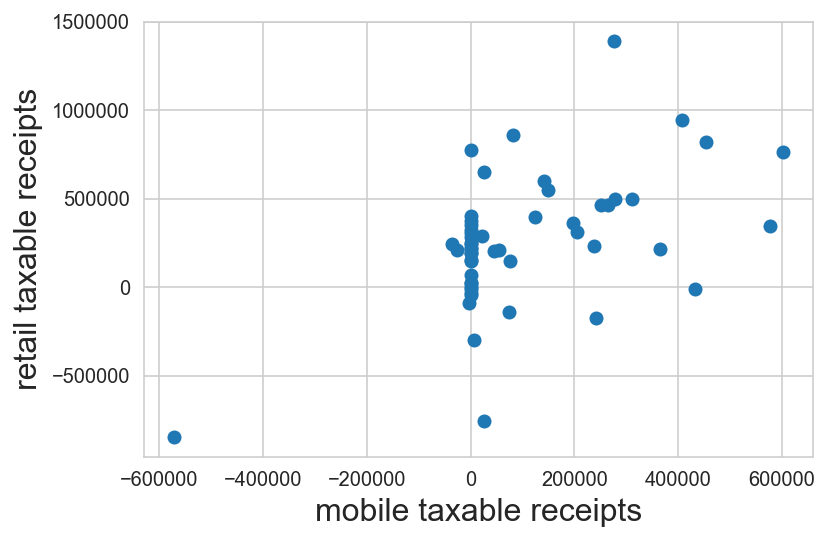

In [40]:
plt.scatter(df['mobile_taxable_receipts'], df['retail_taxable_receipts'])
plt.xlabel("mobile taxable receipts", fontsize = 16)
plt.ylabel("retail taxable receipts", fontsize = 16);

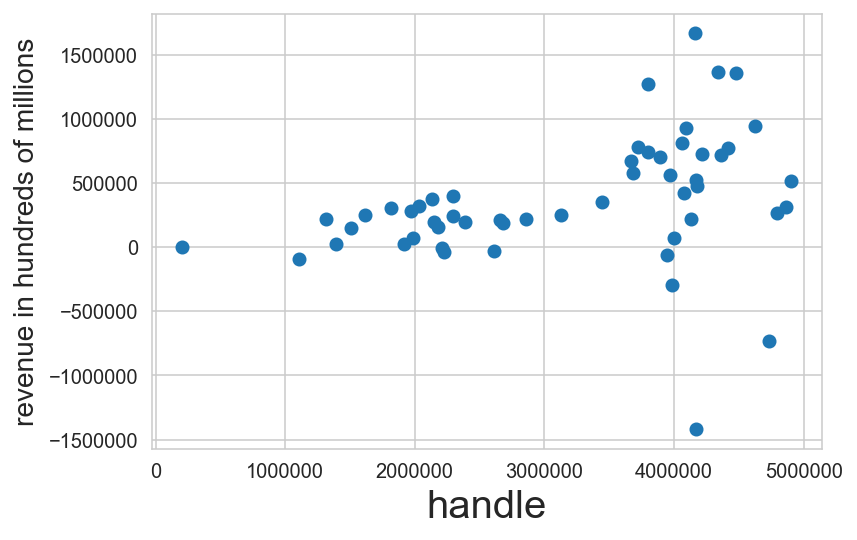

In [41]:
plt.scatter(df['tickets_written'], df['total_taxable_receipts'])
plt.xlabel('handle', fontsize = 20)
plt.ylabel('revenue in hundreds of millions', fontsize = 14);

In [42]:
df.dtypes

tickets_written              int64
voids                        int64
tickets_cashed               int64
mobile_taxable_receipts    float64
retail_taxable_receipts      int64
total_taxable_receipts       int64
privilege_tax                int64
admin_share                  int64
state_share                  int64
dtype: object

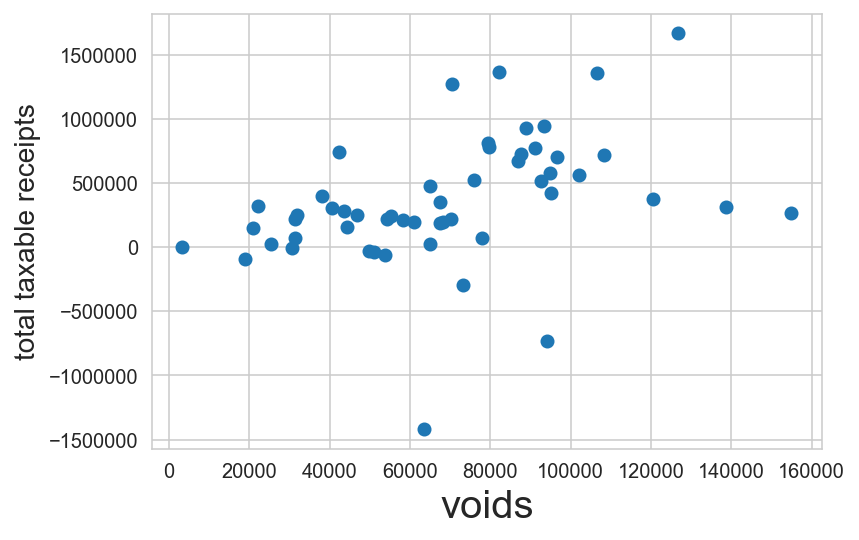

In [43]:
plt.scatter(df['voids'], df['total_taxable_receipts'])
plt.xlabel('voids', fontsize = 20)
plt.ylabel('total taxable receipts', fontsize = 14);

In [ ]:
# obviously change this

df.groupby("week_ending")[["total_taxable_receipts"]].mean().plot(kind = "barh", color="darkcyan", figsize=(8,5))
plt.ylabel("week", fontsize=18)
plt.xlabel("total taxable receipts", fontsize=18)
plt.title("total taxable receipts by week", fontsize=20);

In [ ]:
df.groupby("month")[["revenue"]].mean().plot(kind = "barh", color="darkcyan", figsize=(8,5))
plt.ylabel("month", fontsize=18)
plt.xlabel("revenue", fontsize=18)
plt.title("revenue by month", fontsize=20);

In [ ]:
# Heatmap of the corrleations of features and revenue
plt.figure(figsize = (10,14))
sns.heatmap(df.corr()[["revenue"]].sort_values(by = 'revenue', ascending = False),
                            annot = True,
                            cmap="RdBu",
                            vmin = -1,
                            vmax = 1);

## Preprocessing 

### One-hot Encoding

### PCA


In [ ]:
non_revenue_cols = ["month", "handle", "taxes"]

In [ ]:
# Assigning the new columns to a variable

non_revenue_cols_2 = df[non_revenue_cols]

In [ ]:
non_revenue_cols_2.head()

In [ ]:
ss = StandardScaler()

In [ ]:
scale = ss.fit_transform(non_revenue_cols_2)

In [ ]:
non = pd.DataFrame(scale, columns = non_revenue_cols)

In [ ]:
non.head(10)

### Using a PairGrid to visualize correlation

In [ ]:
g = sns.PairGrid(non)
g = g.map_lower(sns.regplot) # Regression plots in lower triangle.
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle.
g = g.map_diag(plt.hist) # Histograms along diagonal.

plt.show();

### Heat map to visualize correlation

In [ ]:
plt.figure(figsize = (8, 5))
plt.title("Non-Revenue Features Correlation", fontsize = 18);


sns.heatmap(non.corr(), 
            cmap ='RdBu', 
            annot = True,
            vmax = 1,
            vmin = -1)
            
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12); 

In [ ]:
# Fitting PCA on the non-revenue features

non_pca = PCA(n_components=3)
non_pca.fit(non.values)

In [ ]:
# Examining the weights of the principal components

non_pca.components_

In [ ]:
# Examining the explained variance values and explained variance ratios

non_pca.explained_variance_ratio_

In [ ]:
# Transforming the data into the principal component space

# This will transform our our three-dimensional data set into vectors along its three principal components (with zero loss).

non_pca.transform(non.values)

In [ ]:
# Comparing PCA-transformed features to features prior to being PCA-transformed

In [ ]:
pd.DataFrame(non.values).head(10)

In [ ]:
pd.DataFrame(non_pca.transform(non.values)).head(10)

### Using PCA ro reduce dimensionality

## Modeling

In [ ]:
X = df.loc[:, ['month', 'revenue', 'handle', 'taxes']]

In [ ]:
X.head()

In [ ]:
# For my reference

state_revenue_plot = df.plot(kind = "scatter", x = "month", y = "revenue",
             figsize=(10,5),
             s = 12)

plt.xlabel("month", fontsize = 15)
plt.ylabel("revenue", fontsize = 15)

state_revenue_plot.tick_params(axis = 'both',
               which = 'minor',
               labelsize = 14)

In [ ]:
# Initializing an instance of KMeans
# K = 3 clusters

km = KMeans(n_clusters = 3)

In [ ]:
# Fitting our sliced df

km.fit(X)

In [ ]:
# Assigning clusters

df["cluster"] = km.labels_

In [ ]:
df.head(10)

In [ ]:
# Plotting the centroids from the model object with the scatter of 
# "month" and "revenue"

centroid = pd.DataFrame(km.cluster_centers_, columns = ["month", "revenue", "handle", "taxes"])
                                        

In [ ]:
centroid.head()

Plotting methodology:

1. Setting the plot figure with a fig size
2. Assigning colors to centroids
3. Mapping clusters
4. Setting up the plot of clusters
5. Adding the centroids to the plot

In [ ]:
plt.figure(figsize =(10, 8))
colors = ["black", "pink", "blue"]
df["color"] = df["cluster"].map(lambda p: colors[p])

ax = df.plot(kind = "scatter", x = "month", y = "revenue",
    figsize =(12, 10),
    c = df["color"])

centroid.plot(kind = "scatter", x = "month", y = "revenue", 
    marker = "*", 
    c = ["black", "pink", "blue"], 
    s = 1000,
    ax = ax)

Scaling Methodology:

1. Set up StandardScaller
2. Set up X feature and transforming it
3. Set up KMeans
4. Fitting
5. Assinging next round of clusters
6. Creating a df for next round of centroids
7. Plotting

In [ ]:
ss = StandardScaler()

In [ ]:
X_2 = ss.fit_transform(df.loc[:, ["month", "revenue"]])

In [ ]:
km_2 = KMeans(n_clusters = 3)

In [ ]:
km_2.fit(X_2)

In [ ]:
df['cluster'] = km_2.labels_

In [ ]:
df.head(10)

In [ ]:
centroid = pd.DataFrame(ss.inverse_transform(km_2.cluster_centers_), 
      columns =["month", "revenue"])

In [ ]:
centroid.head(10) 

In [ ]:
plt.figure(figsize=(10,6))

colors = ["black", "pink", "blue"]

df['color'] = df['cluster'].map(lambda p: colors[p])

ax = df.plot(    
    kind = "scatter",  x = "month", y = "revenue", 
    figsize = (10,6),
    c = df["color"])

centroid.plot(kind = "scatter", x ="month", y = "revenue",
    marker = "*", 
    c = ["black", "pink", "blue"],
    s = 1000,
    ax = ax)

In [ ]:
silhouette_score(X_2, km_2.labels_)

### Time Series

In [44]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [45]:
df.head()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
week_ending,,,,,,,,,
2019-01-05,4796300,154935,4376920,54089.0,210356,264445,26445,3967,22478
2019-01-12,4860953,138666,4411529,21356.0,289402,310758,31076,4661,26414
2019-01-19,4167883,75981,3572071,122956.0,396875,519831,51983,7797,44186
2019-01-26,3983320,73280,4202907,6185.0,-299052,-292867,-29287,-4393,-24894
2019-02-02,4622730,93425,3585239,81104.0,862961,944066,94407,14161,80246


In [ ]:
df.set_index('week_ending', inplace=True)


In [ ]:
df.head()

In [ ]:
# Code written by Joseph Nelson. ARIMA Lesson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [ ]:
# Cite the source

def ACF_PACF(df, col_string, lags):
    ACF = plot_acf(df[col_string], lags = lags);
    PACF = plot_pacf(df[col_string], lags = lags);
    return ACF, PACF

## Time Series Modeling

In [ ]:
df.head()